In [6]:
import os
import torch
import torchaudio
import sys
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, "../src_torch_extend"))
from IPython.display import Audio
import pickle
import soundfile as sf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

from Base import MultiSTFT, MultiISTFT

number_of_notes = [36, 15, 15]
audio_src_dir = "Shubert_v2"
dict_dir = "dict"

dict_path = os.path.join(notebook_dir, "../", dict_dir)


ModuleNotFoundError: No module named 'Base'

In [8]:
import os
import pickle
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# Define directories based on your structure
notebook_dir = os.getcwd()  # Should be: C:\Users\robin\Documents\2024-2025\ATIAM\PAM\PAM-Music-Source-Separation\notebooks
# Data directory: adjust relative to the notebook directory
audio_src_dir = os.path.join(notebook_dir, "../data_PAM/real/Schubert_instruments_seuls")
# Dictionary directory for saving the results
dict_dir = os.path.join(notebook_dir, "../dict")

# Create the dictionary directory if it does not exist
if not os.path.exists(dict_dir):
    os.makedirs(dict_dir)
    print(f"Created directory: {dict_dir}")
else:
    print(f"Directory already exists: {dict_dir}")

# List of audio file names
audio_src_names = np.array(["piano_brut.wav", "clarinette_brut.wav", "violon_brut.wav"])
audio_paths = [os.path.join(audio_src_dir, audio_src_name) for audio_src_name in audio_src_names]

# Parameters for STFT and NMF
n_fft = 2048
hop_length = 512
number_of_notes = [36, 15, 15]  # Number of components per instrument

W = []  # To store the spectral basis matrices for each instrument
H = []  # To store the activation matrices for each instrument
max_T = 0  # To track the maximum time frames across all instruments

# Process each instrument file
for idx, audio_path in enumerate(audio_paths):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=44100)
    # Normalize the audio (avoid clipping)
    y /= np.abs(y).max() * 1.2
    # Compute the STFT magnitude
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    # Apply NMF using KL divergence (beta_loss='kullback-leibler')
    model = NMF(n_components=number_of_notes[idx],
                init='nndsvda', solver='mu',
                beta_loss='kullback-leibler',
                random_state=42, max_iter=2000)
    W_k = model.fit_transform(D)  # Shape: [F, K]
    H_k = model.components_         # Shape: [K, T]
    print(f'Reconstruction error: {model.reconstruction_err_}, iterations: {model.n_iter_} for {audio_src_names[idx]}')
    # Track maximum number of time frames
    max_T = max(max_T, H_k.shape[1])
    # Zero-pad W_k along the component axis so that all W_k have the same number of columns = max(number_of_notes)
    pad_width = max(number_of_notes) - number_of_notes[idx]
    W_k = np.pad(W_k, ((0, 0), (0, pad_width)))
    W.append(W_k)
    H.append(H_k)

# Zero-pad each H_k along the time axis to have the same number of frames (max_T)
H = [np.pad(H_k, ((0, max(number_of_notes)-H_k.shape[0]), (0, max_T - H_k.shape[1]))) for H_k in H]

# Convert lists to numpy arrays
W = np.array(W)  # Final shape: [N, F, max(number_of_notes)]
H = np.array(H)  # Final shape: [N, max(number_of_notes), max_T]

# Save the resulting dictionary matrices to disk
with open(os.path.join(dict_dir, "W.pkl"), "wb") as f:
    pickle.dump(W, f)
with open(os.path.join(dict_dir, "H.pkl"), "wb") as f:
    pickle.dump(H, f)

print("Dictionary matrices W and H saved successfully.")


Created directory: c:\Users\robin\Documents\2024-2025\ATIAM\PAM\PAM-Music-Source-Separation\notebooks\../dict
Reconstruction error: 236.4034471909198, iterations: 210 for piano_brut.wav
Reconstruction error: 907.1816590407899, iterations: 80 for clarinette_brut.wav
Reconstruction error: 537.5724079135758, iterations: 170 for violon_brut.wav
Dictionary matrices W and H saved successfully.


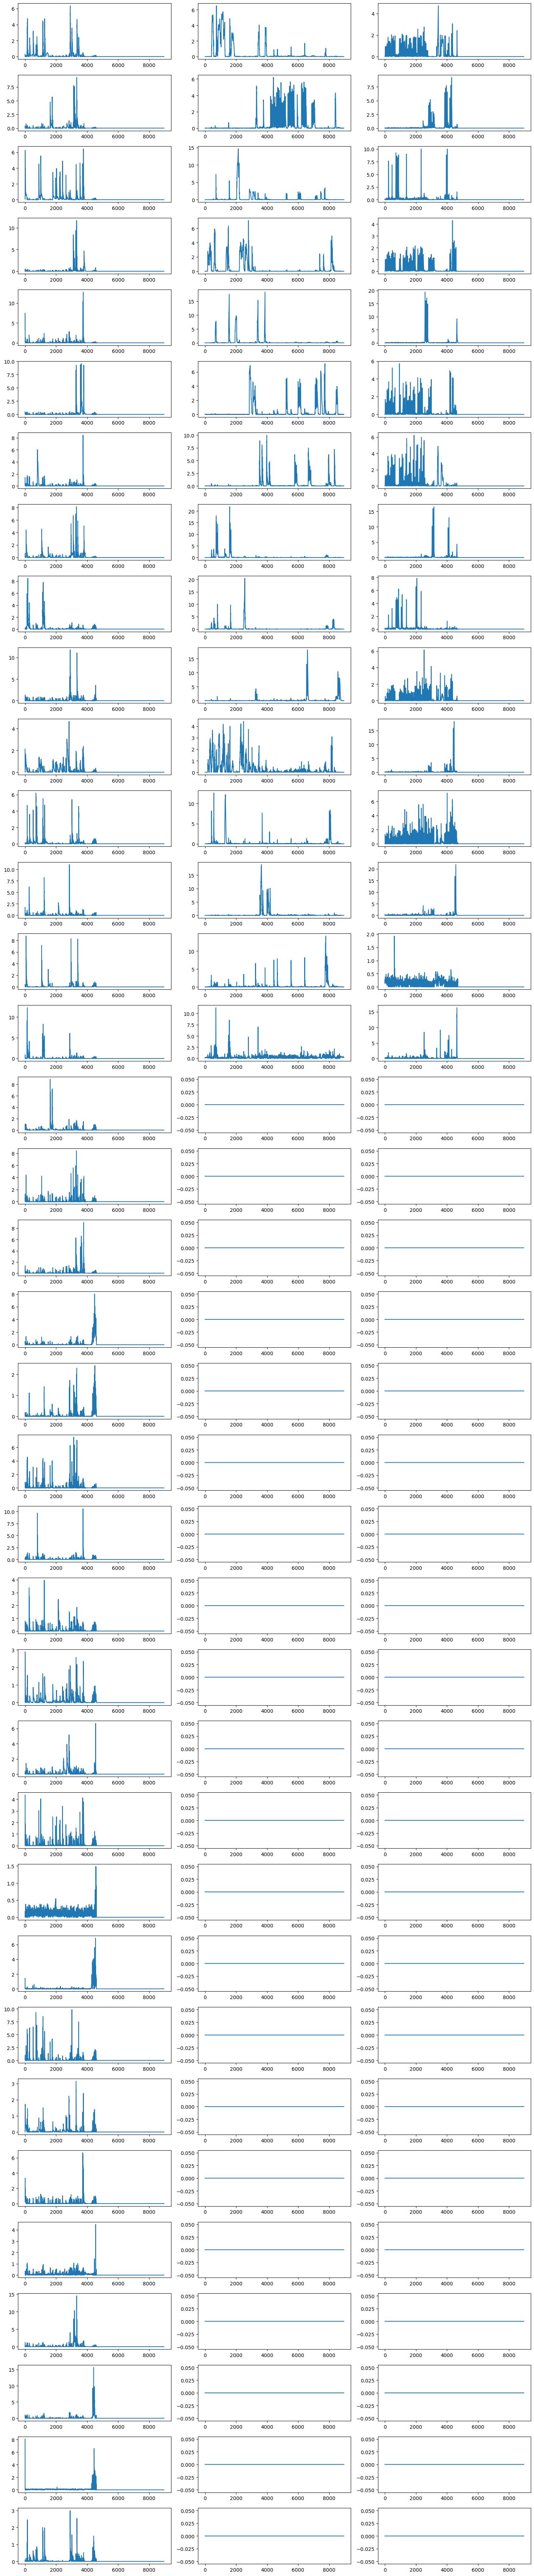

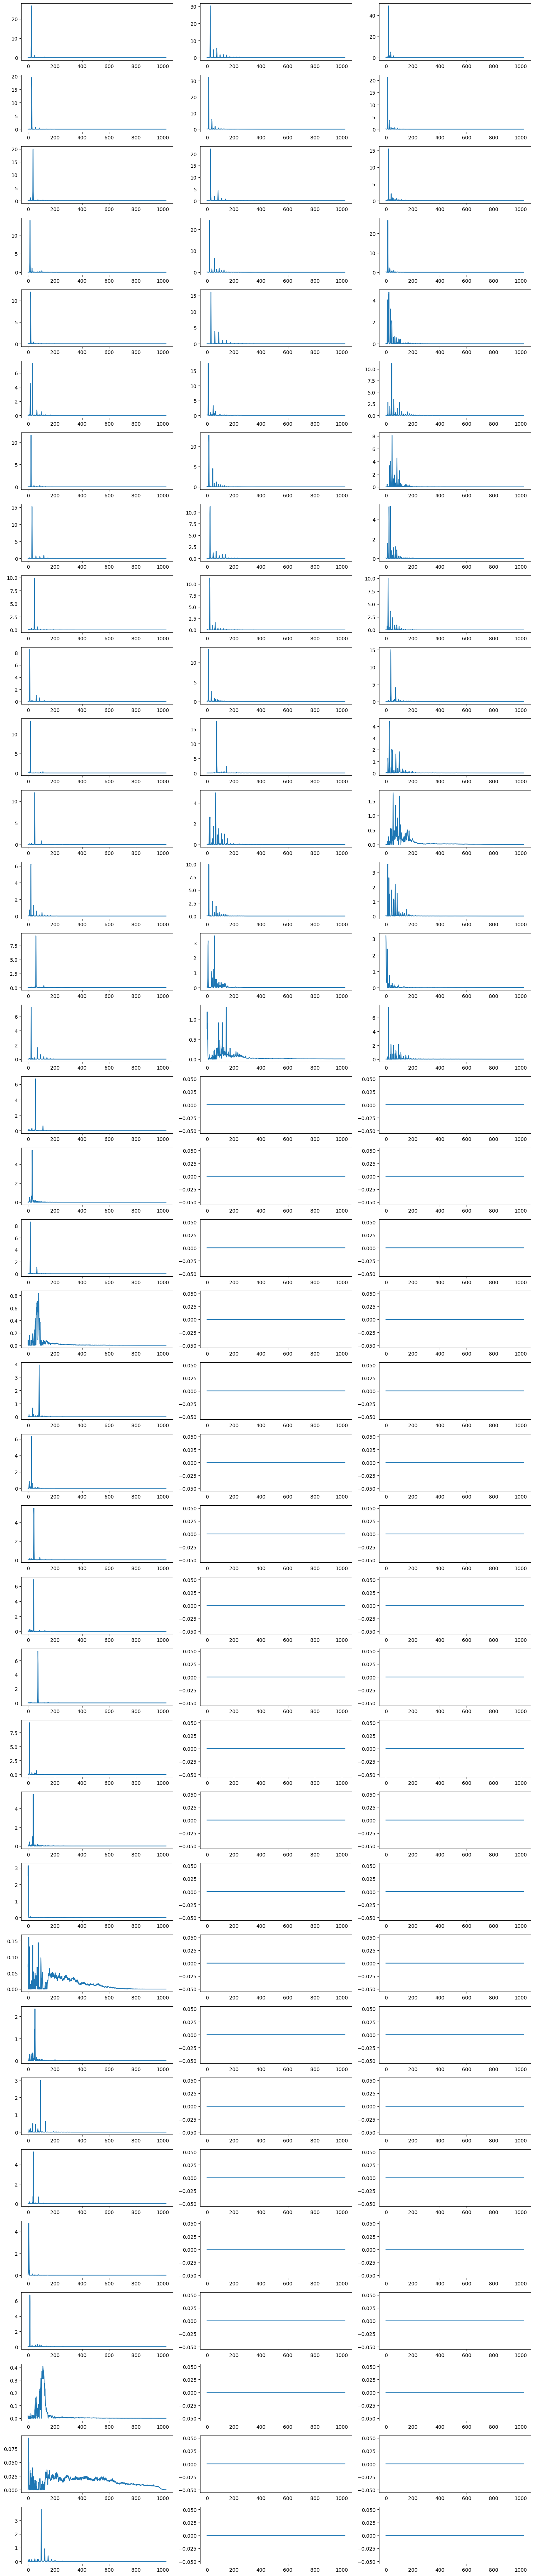

In [9]:
try :
    W, H
except NameError:
    print("Load W, H from pickle file")
    with open(os.path.join(dict_path, "W.pkl"), "rb") as f:
        W = pickle.load(f)
    with open(os.path.join(dict_path, "H.pkl"), "rb") as f:
        H = pickle.load(f)

K = max(number_of_notes)
fig, axs = plt.subplots(K, 3, figsize=(15, K*2))
for idx in range(K):
    for i in range(3):
        axs[idx, i].plot(H[i, idx, :])
    plt.tight_layout()
plt.show()

fig, axs = plt.subplots(K, 3, figsize=(15, K*2))
for idx in range(K):
    for i in range(3):
        axs[idx, i].plot(W[i, :, idx])
    plt.tight_layout()
plt.show()